Feature: SeniorCitizen (Chi-Squared)
  Error: Contingency table is empty or not suitable for chi-squared test

Feature: tenure (K-S)
  Statistic: 0.0127
  P-Value: 0.9354
  Drift Detected: False

Feature: MonthlyCharges (K-S)
  Statistic: 0.0217
  P-Value: 0.3719
  Drift Detected: False



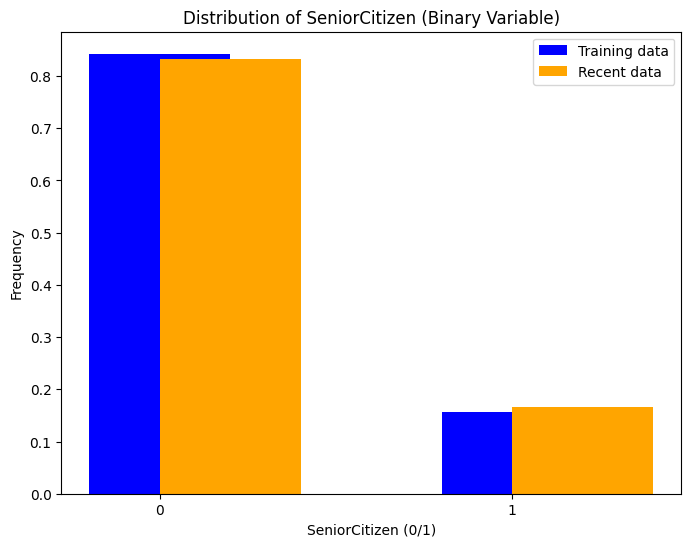

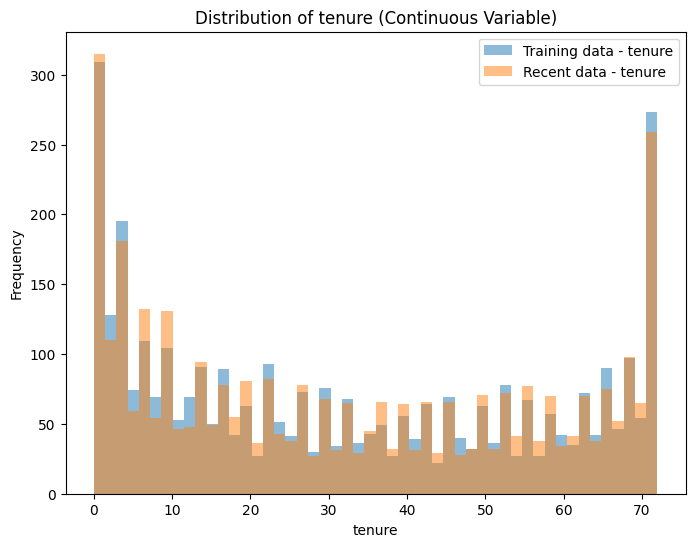

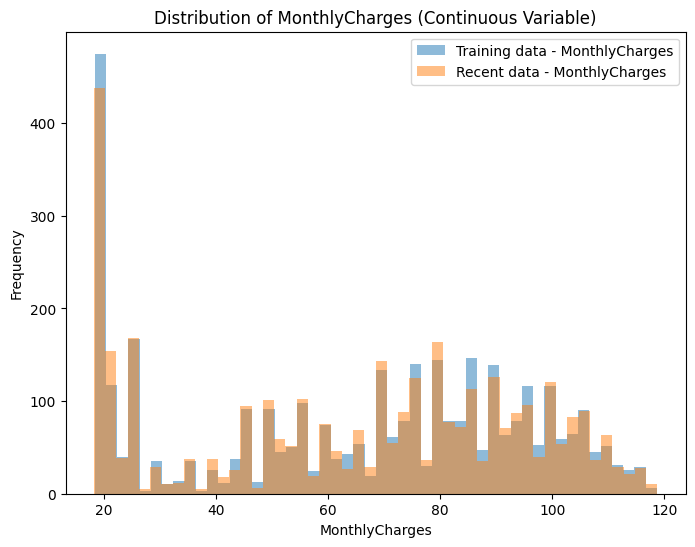

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, chi2_contingency

# Load the dataset into a pandas DataFrame
dataset_path = r'C:\Users\tahsi\OneDrive\Desktop\python_ws\telco-churn.csv'
df = pd.read_csv(dataset_path)

# Function to detect data drift using K-S test or Chi-Squared for binary variables
def detect_data_drift(train_df, recent_df, alpha=0.05):
    drift_report = {}
    # Select numeric columns and handle binary separately
    numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
    for column in numeric_cols:
        if column in recent_df.columns:
            # Handle binary variables (with only 2 unique values)
            if train_df[column].nunique() <= 2:  
                contingency_table = pd.crosstab(train_df[column], recent_df[column])
                
                # Ensure the contingency table is not empty before running chi2_contingency
                if contingency_table.size > 0 and contingency_table.shape == (2, 2):
                    chi2, p, _, _ = chi2_contingency(contingency_table)
                    drift_report[column] = {
                        'Test Type': 'Chi-Squared',
                        'Statistic': chi2,
                        'P-Value': p,
                        'Drift Detected': p < alpha
                    }
                else:
                    drift_report[column] = {
                        'Test Type': 'Chi-Squared',
                        'Error': 'Contingency table is empty or not suitable for chi-squared test'
                    }
            else:  # Use K-S test for continuous variables
                statistic, p_value = ks_2samp(train_df[column], recent_df[column])
                drift_report[column] = {
                    'Test Type': 'K-S',
                    'Statistic': statistic,
                    'P-Value': p_value,
                    'Drift Detected': p_value < alpha
                }
    return drift_report

# Split the data into training and recent datasets
split_index = len(df) // 2
train_df = df.iloc[:split_index]
recent_df = df.iloc[split_index:]

# Detect data drift
drift_report = detect_data_drift(train_df, recent_df)

# Print the drift report for binary and numeric features
for feature, report in drift_report.items():
    print(f"Feature: {feature} ({report['Test Type']})")
    if 'Error' in report:
        print(f"  Error: {report['Error']}")
    else:
        print(f"  Statistic: {report['Statistic']:.4f}")
        print(f"  P-Value: {report['P-Value']:.4f}")
        print(f"  Drift Detected: {report['Drift Detected']}")
    print()

# Plot histograms or bar plots for binary and numeric variables
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns

# Loop through the numeric columns and plot histograms for continuous data and bar plots for binary data
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    
    if train_df[col].nunique() <= 2:  # If binary variable
        train_counts = train_df[col].value_counts(normalize=True)
        recent_counts = recent_df[col].value_counts(normalize=True)
        
        labels = ['0', '1']
        train_values = [train_counts.get(0, 0), train_counts.get(1, 0)]
        recent_values = [recent_counts.get(0, 0), recent_counts.get(1, 0)]

        x = range(len(labels))
        plt.bar(x, train_values, width=0.4, label='Training data', color='blue', align='center')
        plt.bar(x, recent_values, width=0.4, label='Recent data', color='orange', align='edge')
        plt.xticks(x, labels)
        plt.xlabel(f'{col} (0/1)')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {col} (Binary Variable)')
    else:  # For continuous/numeric variables
        plt.hist(train_df[col], bins=50, alpha=0.5, label=f'Training data - {col}')
        plt.hist(recent_df[col], bins=50, alpha=0.5, label=f'Recent data - {col}')
        plt.xlabel(f'{col}')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {col} (Continuous Variable)')
    
    plt.legend()
    plt.show()
